# `MEDUSA`
aka. Dynamic-Prospective LCA aka. Union(premise, temporalis)

In [7]:
from bw_temporalis import easy_timedelta_distribution, TemporalDistribution
import medusa
import bw2data as bd
import bw2calc as bc
import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'tictac_lca'

In [2]:
bd.projects.delete_project("medusa_hydrogen_example")
bd.projects.purge_deleted_directories()

2

In [3]:
bd.projects.set_current("medusa_hydrogen_example")

### Setup of our Example
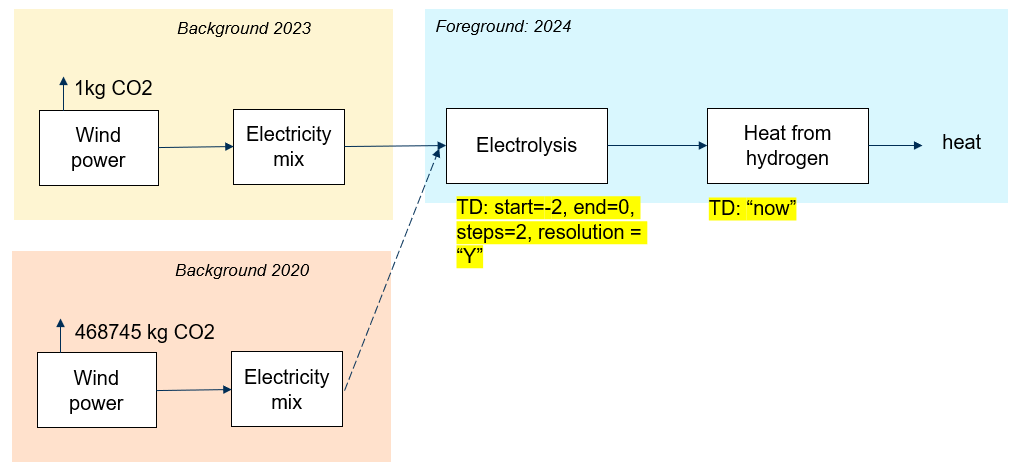

In [4]:
bd.Database('temporalis-bio').write({
    ('temporalis-bio', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "temporalis code": "co2",
    },
})

bd.Database('background_2024').write({
    ('background_2024', 'electricity_mix'): {
        'name': 'Electricity mix',
        'location': 'somewhere',
        'reference product': 'electricity mix',
        'exchanges': [
            {
                'amount': 1,
                'type': 'production',
                'input': ('background_2024', 'electricity_mix'),
            },
            {
                'amount': 1,
                'type': 'technosphere',
                'input': ('background_2024', 'electricity_wind'),
            },
        ]
    },
    ('background_2024', 'electricity_wind'): {
        'name': 'Electricity production, wind',
        'location': 'somewhere',
        'reference product': 'electricity, wind',
        'exchanges': [
            {
                'amount': 1,
                'type': 'production',
                'input': ('background_2024', 'electricity_wind'),
            },
            {
                'amount': 0.9,
                'type': 'biosphere',
                'input': ('temporalis-bio', 'CO2'),
            },
        ]
    }
})

bd.Database('background_2020').write({
    ('background_2020', 'electricity_mix'): {
        'name': 'Electricity mix',
        'location': 'somewhere',
        'reference product': 'electricity mix',
        'exchanges': [
            {
                'amount': 1,
                'type': 'production',
                'input': ('background_2020', 'electricity_mix'),
            },
            {
                'amount': 1,
                'type': 'technosphere',
                'input': ('background_2020', 'electricity_wind'),
            },
        ]
    },
    ('background_2020', 'electricity_wind'): {
        'name': 'Electricity production, wind',
        'location': 'somewhere',
        'reference product': 'electricity, wind',
        'exchanges': [
            {
                'amount': 1,
                'type': 'production',
                'input': ('background_2020', 'electricity_wind'),
            },
            {
                'amount': 1.2,
                'type': 'biosphere',
                'input': ('temporalis-bio', 'CO2'),
            },
        ]
    }
})

bd.Database('foreground').write({
    # ('foreground', 'someotherprocess'): {
    #     'name': 'some other process',
    #     'location': 'somewhere',
    #     'reference product': 'hydrogen',
    #     'exchanges': [
    #         {
    #             'amount': 1,
    #             'type': 'production',
    #             'input': ('foreground', 'someotherprocess'),
    #         },
    #         {
    #             'amount': 6,
    #             'type': 'technosphere',
    #             'input': ('background_2024', 'electricity_mix'),
    #             'temporal_distribution': # e.g. because some hydrogen was stored in the meantime
    #                 TemporalDistribution(
    #                     date=np.array([-8, -4, 0], dtype='timedelta64[M]'),  # `M` is months
    #                     amount=np.array([0.2, 0.6, 0.2])
    #                 ),
    #         },
    #     ]
    # },
    ('foreground', 'electrolysis'): {
        'name': 'Hydrogen production, electrolysis',
        'location': 'somewhere',
        'reference product': 'hydrogen',
        'exchanges': [
            {
                'amount': 1,
                'type': 'production',
                'input': ('foreground', 'electrolysis'),
            },
            {
                'amount': 5,
                'type': 'technosphere',
                'input': ('background_2024', 'electricity_mix'),
                'temporal_distribution': # e.g. because some hydrogen was stored in the meantime
                    TemporalDistribution(
                        date=np.array([-8, -4, 0], dtype='timedelta64[M]'),  # `M` is months
                        amount=np.array([0.2, 0.6, 0.2])
                    ),
                # 'temporal_distribution': # e.g. because some hydrogen was stored in the meantime
                #     easy_timedelta_distribution(
                #     start=-1,
                #     end=0, # Range includes both start and end
                #     resolution="Y",  # M for months, Y for years, etc.
                #     steps=2,
                # ),
                
            },
        ]
    },
    ('foreground', 'heat_from_hydrogen'): {
        'name': 'Heat production, hydrogen',
        'location': 'somewhere',
        'reference product': 'heat',
        'exchanges': [
            {
                'amount': 1,
                'type': 'production',
                'input': ('foreground', 'heat_from_hydrogen'),
            },
            {
                'amount': 0.7,
                'type': 'technosphere',
                'input': ('foreground', 'electrolysis'),
                'temporal_distribution': # e.g. because some hydrogen was stored in the meantime
                    easy_timedelta_distribution(
                    start=-2,
                    end=0, # Range includes both start and end
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=2,
                ),
            },
        ]
    },
})

100%|██████████| 1/1 [00:00<00:00, 3246.37it/s]

Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 27324.46it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 49932.19it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 3/3 [00:00<00:00, 49344.75it/s]

Vacuuming database 


In [5]:
bd.Method(("GWP", "example")).write([
    (('temporalis-bio', "CO2"), 1),
])

In [6]:
demand = {('foreground', 'heat_from_hydrogen'): 1}
gwp = ('GWP', 'example')

# Static LCA

In [7]:
slca = bc.LCA(demand, gwp)
slca.lci()
slca.lcia()
print(f'Static LCA score: {slca.score}')

Static LCA score: 18.89999917745591


# `MEDUSA` LCA

A MEDUSA LCA builds upon a static LCA, but adds a temporal dimensions, linking to prospective LCA databases. Similarly to a `Temporalis LCA`, the supply chain graph is traversed, taking into account temporal distributions of the edges. 

For now, only the foreground system is assumed to have temporal distributions. Therefore, we define a filter function, that tells to EdgeExtracter (which is doing the actual graph traversal and saves the edges with respective timestamps), when a database that is known to have no temporal distributions (i.e., the prospective background databases) is reached, so that the traversal can be stopped.

In [8]:
SKIPPABLE = [node.id for node in bd.Database('background_2020')] + [
    node.id for node in bd.Database('background_2024')
]

def filter_function(database_id: int) -> bool:
    return database_id in SKIPPABLE

Now we can do the graph traversal and create a timeline of edges:

In [9]:
eelca = EdgeExtracter(slca, edge_filter_function=filter_function)
timeline = eelca.build_edge_timeline()

Starting graph traversal
Calculation count: 4


Next, we define a dictionary containing the dates of our prospective background databases. Using this, we can create a timeline dataframe. 

The dates of the edges are mapped to the prospective background databases; interpolation is used for dates in between the dates of the background databases. The default is linear interpolation, another currently included option is "nearest", choosing the next best fitting database.

In [10]:
timeline

[Edge(distribution=TemporalDistribution instance with 1 values and total: 1, leaf=False, consumer=-1, producer=8, value=1),
 Edge(distribution=TemporalDistribution instance with 2 values and total: 0.7, leaf=False, consumer=8, producer=7, value=TemporalDistribution instance with 2 values and total: 0.7),
 Edge(distribution=TemporalDistribution instance with 2 values and total: 3.5, leaf=False, consumer=7, producer=6, value=5.0),
 Edge(distribution=TemporalDistribution instance with 6 values and total: 21, leaf=True, consumer=6, producer=2, value=TemporalDistribution instance with 3 values and total: 6)]

In [11]:
d = timeline[1]
d

Edge(distribution=TemporalDistribution instance with 2 values and total: 0.7, leaf=False, consumer=8, producer=7, value=TemporalDistribution instance with 2 values and total: 0.7)

In [12]:
d.distribution.date

array(['2022-01-26T05:07:25', '2024-01-26T16:45:49'],
      dtype='datetime64[s]')

In [13]:
database_date_dict = {
            datetime.strptime("2020", "%Y"): 'background_2020',
            datetime.strptime("2024", "%Y"): 'background_2024',
        }

timeline_df = create_grouped_edge_dataframe(timeline, database_date_dict, interpolation_type="linear")
timeline_df

All databases in database_date_dict exist as brightway project databases


,year,producer,consumer,amount,total,share,date,interpolation_weights,producer_name,consumer_name,timestamp
0,2021,2,6,8.4,6.0,0.4,2021-01-01,"{'background_2020': 0.7494866529774127, 'backg...",Electricity mix,some other process,2021
1,2022,2,6,2.1,6.0,0.1,2022-01-01,"{'background_2020': 0.4996577686516085, 'backg...",Electricity mix,some other process,2022
2,2022,6,7,1.75,5.0,0.5,2022-01-01,"{'background_2020': 0.4996577686516085, 'backg...",some other process,"Hydrogen production, electrolysis",2022
3,2022,7,8,0.35,0.7,0.5,2022-01-01,"{'background_2020': 0.4996577686516085, 'backg...","Hydrogen production, electrolysis","Heat production, hydrogen",2022
4,2023,2,6,8.4,6.0,0.4,2023-01-01,"{'background_2020': 0.2498288843258042, 'backg...",Electricity mix,some other process,2023
5,2024,2,6,2.1,6.0,0.1,2024-01-01,{'background_2024': 1},Electricity mix,some other process,2024
6,2024,6,7,1.75,5.0,0.5,2024-01-01,{'background_2024': 1},some other process,"Hydrogen production, electrolysis",2024
7,2024,7,8,0.35,0.7,0.5,2024-01-01,{'background_2024': 1},"Hydrogen production, electrolysis","Heat production, hydrogen",2024
8,2024,8,-1,1.0,1.0,1.0,2024-01-01,{'background_2024': 1},"Heat production, hydrogen",-1,2024


Now, we want to create a datapackage that takes care of relinking processes to our prospective databases. To do so, we need to provide the timeline dataframe, the dict of prospective databases and corresponding years, and a new dictionary that defines at which point in time our functional unit is assessed *(We can probably include this information in the database_date_dict in the future, but for now, this works)*.

In [14]:
demand_timing_dict = create_demand_timing_dict(timeline_df, demand)

dp = create_datapackage_from_edge_timeline(timeline_df, database_date_dict, demand_timing_dict)

Finally, we just have to reformat our input data for the LCA, add our datapackage containing the patches, and run the lca.

In [15]:
fu, data_objs, remapping = prepare_medusa_lca_inputs(demand=demand, demand_timing_dict=demand_timing_dict, method=gwp) 
lca = bc.LCA(fu, data_objs = data_objs + [dp], remapping_dicts=remapping)
lca.lci()
lca.lcia()

Let's take a look at the results:

In [16]:
print('New MEDUSA LCA Score:', lca.score)
print('Old static LCA Score:', slca.score)

New MEDUSA LCA Score: 17.63827505348644
Old static LCA Score: 18.89999917745591


In [17]:
df = pd.DataFrame(lca.technosphere_matrix.toarray())
df.rename(lca.dicts.activity.reversed, inplace=True, axis=0)
df.rename(lca.dicts.activity.reversed, inplace=True, axis=1)
df


,2,3,4,5,6,7,8,2002021,2002022,2002023,2002024,6002022,6002024,7002022,7002024,8002024
2,1.0,0.0,0.0,0.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.601232,-1.800411,0.0,0.0,0.0
3,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.798768,-0.599589,0.0,0.0,0.0
5,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,-0.7,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2002021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2002022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2002023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [18]:
rem = lca.remapping_dicts['activity']
rem

{1: ('temporalis-bio', 'CO2'),
 2: ('background_2024', 'electricity_mix'),
 3: ('background_2024', 'electricity_wind'),
 4: ('background_2020', 'electricity_mix'),
 5: ('background_2020', 'electricity_wind'),
 6: ('foreground', 'someotherprocess'),
 7: ('foreground', 'electrolysis'),
 8: ('foreground', 'heat_from_hydrogen')}

In [19]:
dict(lca.dicts.activity)

{2: 0,
 3: 1,
 4: 2,
 5: 3,
 6: 4,
 7: 5,
 8: 6,
 2002021: 7,
 2002022: 8,
 2002023: 9,
 2002024: 10,
 6002022: 11,
 6002024: 12,
 7002022: 13,
 7002024: 14,
 8002024: 15}